# Convolution Neural Network: Men vs Women Classification

Found 1174 images belonging to 1 classes.
Found 465 images belonging to 1 classes.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import cv2


In [2]:
# Check Image from Dataset
img = image.load_img("genderdataset/trainset/trainset/img.jpg")

<IPython.core.display.Javascript object>

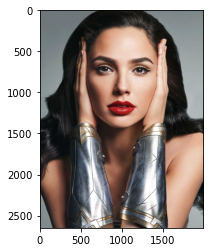

In [3]:
plt.imshow(img)

In [4]:
cv2.imread("genderdataset/trainset/trainset/img.jpg").shape

(2650, 1988, 3)

### Train And test Dataset Usinng ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'genderdataset/trainset/',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'genderdataset/validation/',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')


Found 1174 images belonging to 1 classes.
Found 465 images belonging to 1 classes.


## Build A CNN Model Using Hyperparameter

In [10]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=150, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(128,128,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=150, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [11]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [12]:
# kernel Tuner Help To Choose Rigght Parameter For Our Model
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=2,directory='output',project_name="GenderClassification_Cnn")

INFO:tensorflow:Reloading Oracle from existing project output\GenderClassification_Cnn\oracle.json
INFO:tensorflow:Reloading Tuner from output\GenderClassification_Cnn\tuner0.json


In [13]:
tuner_search.search(train_generator, steps_per_epoch=10, epochs=2, validation_data=validation_generator)

Trial 1 Complete [00h 06m 46s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 06m 46s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Set MOdel For Best Parameter
model=tuner_search.get_best_models(num_models=1)[0]

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 80)      128080    
_________________________________________________________________
flatten (Flatten)            (None, 1152000)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                73728064  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 73,861,658
Trainable params: 73,861,658
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Let's Fit Model 
model.fit(train_generator, epochs=3, validation_data=validation_generator, initial_epoch=2)